<div align="center">
<h1>Appendix</h1>
</div>

In [1]:
# Import necessary packages and modules
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os

In [3]:
# File path-related constants
General_Path = # Your path here
Image_Path = os.path.join(General_Path, 'images')

# Image-related constants
Image_Height = 484
Image_Width = 644
File_Extension = '.bmp'
Cropped_Left = int(Image_Width*0.45)
Cropped_Right = int(Image_Width*0.85)
Cropped_Top = int(Image_Height*0.1)
Cropped_Bottom = int(Image_Height*0.65)

# Signal related constants
Min_Wavelength = 470
Max_Wavelength = 740
Num_Wavelengths = 271


In [4]:
# Function used to return the Gray values (i.e. intensity) of a specific pixel for a given image
def gray_values(wavelength, pixel):
    this_image_path = os.path.join(Image_Path, str(int(wavelength)) + '.bmp')
    this_image = Image.open(this_image_path)
    rgb = this_image.getpixel(pixel)
    gray = sum(rgb[:3])
    return gray

In [5]:
# Parameters
Sampling_Factor = 10                # Factor equal to the number of equally-spaced divisions of the image, used for sampling
Testing_Ratio = 0.2                 # Proportion of data points to be considered for testing
seed = 30                           # Seed for initialising random state
Num_Folds = 5                       # Number of folds for k-cross validation
int_factor = 5                      # Interpolation factor                           
show_folds = True                   # Parameter

In [6]:
# Constants
Num_Pixels = Sampling_Factor**2                     # Number of pixels of the image to sample = number of features
datapoints_intp_num = Num_Wavelengths*int_factor        # Number of data points after interpolation

<div align="center">
    <h2>Preprocessing</h2>
</div>


In [7]:
# Construct NumPy array containing an evenly spaced set of points corresponding to pixels on the image
x_coords = np.linspace(Cropped_Left, Cropped_Right, Sampling_Factor)
y_coords = np.linspace(Cropped_Top, Cropped_Bottom, Sampling_Factor)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
pixels = np.column_stack((x_grid.flatten(), y_grid.flatten()))

<div align="center">
    <h3>Interpolation</h3>
</div>


In [8]:
# Equally spaced NumPy array containing the labels
y = np.linspace(Min_Wavelength, Max_Wavelength, Num_Wavelengths)

# Construct the feature matrix
X = np.zeros((Num_Wavelengths, Num_Pixels))
for i in range(Num_Wavelengths):
  for j in range(Num_Pixels):
      X[i, j] = gray_values(y[i], tuple(pixels[j]))

# defining arrays for the features and interpolated labels
y_interpolated = np.linspace(Min_Wavelength, Max_Wavelength, datapoints_intp_num)
X_interpolated= np.zeros((datapoints_intp_num, Num_Pixels))

In [9]:
# Interpolate the feature data for the desired wavelengths
for r in range(Num_Pixels):
   X_interpolated[:,r] = sp.interpolate.UnivariateSpline(y, X[:, r])(y_interpolated[:])

# Convert the result to a NumPy array
X_interpolated = np.array(X_interpolated)

<div align="center">
    <h3>Spliting the data</h3>
</div>


In [10]:
# Separate the labels of the dataset into two arrays for training and testing
np.random.seed(seed)
X_trainNVal, X_test, y_trainNVal, y_test = train_test_split(X_interpolated, y_interpolated, test_size=0.2, random_state=seed)

<div align="center">
    <h3>Normalization</h3>
</div>

In [11]:
# Normalizing the data

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform it
X_train_scaled = scaler.fit_transform(X_trainNVal)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

<div align="center">
    <h2>Linear Regression</h2>
</div>


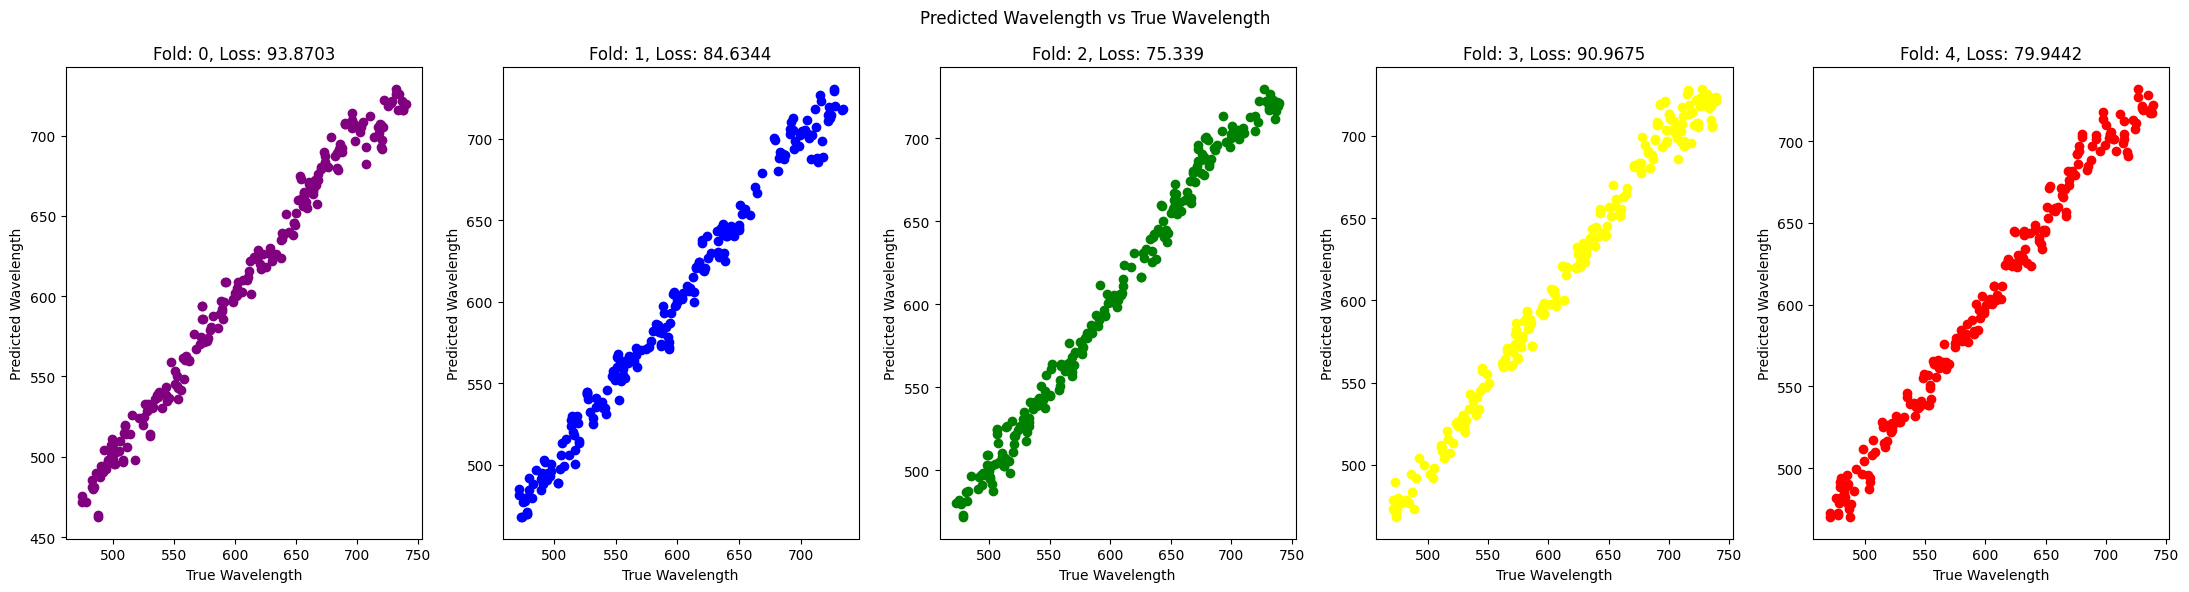

Mean MSE across all folds in training set: 64.71325185088597
Mean MSE across all folds in validation set: 84.95109234853764
MSE for test data: 79.8801843960225


In [18]:
# Perform KFold cross-validation
kf = KFold(n_splits=Num_Folds)
reg_val_scores = []
reg_train_scores = []

# Create a figure with subplots
colours = ('purple', 'blue', 'green', 'yellow', 'red')
fig, axs = plt.subplots(nrows=1, ncols=Num_Folds, figsize=(22, 6))

for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train, y_val = y_trainNVal[train_index], y_trainNVal[val_index]

    # Create a Linear Regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    #make predictions on the training data
    y_train_pred = model.predict(X_train)

    # Make predictions on the validation data
    y_val_pred = model.predict(X_val)

    # Caclulate Mean Squared Error (MSE) for this fold
    mse_train = mean_squared_error(y_train, y_train_pred)
    reg_train_scores.append(mse_train)
    mse_val = mean_squared_error(y_val, y_val_pred)
    reg_val_scores.append(mse_val)

    if mse_val == min(reg_val_scores):
       best_fold = fold_num
       y_test_pred = model.predict(X_test_scaled)

    # Add the figure to the plot
    axs[fold_num].scatter(y_val, y_val_pred, color=colours[fold_num])
    axs[fold_num].set_xlabel('True Wavelength')
    axs[fold_num].set_ylabel('Predicted Wavelength')
    axs[fold_num].set_title(f'Fold: {fold_num}, Loss: {round(mse_val, 4)}')

plt.suptitle('Predicted Wavelength vs True Wavelength')
plt.tight_layout()
plt.show()

mean_mse_train1 = np.mean(reg_train_scores)
mean_mse_val1 = np.mean(reg_val_scores)
test1_mse = mean_squared_error(y_test, y_test_pred)
print('Mean MSE across all folds in training set:', mean_mse_train1)
print('Mean MSE across all folds in validation set:', mean_mse_val1)
print('MSE for test data:', test1_mse)

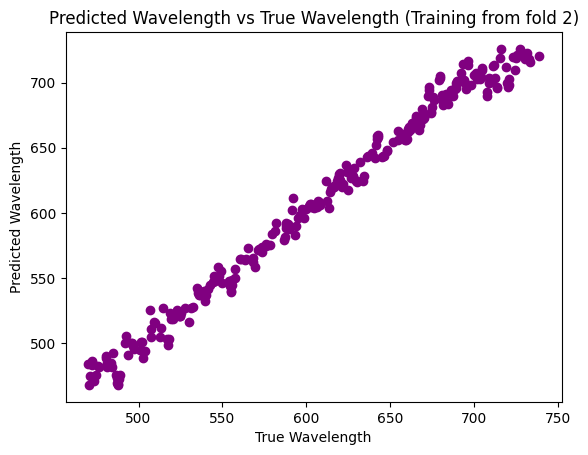

In [13]:
plt.scatter(y_test, y_test_pred, color='purple')
plt.xlabel('True Wavelength')
plt.ylabel('Predicted Wavelength')
plt.title(f'Predicted Wavelength vs True Wavelength (Training from fold {best_fold})')
plt.show()

<div align="center">
    <h2>MLP Regression</h2>
</div>

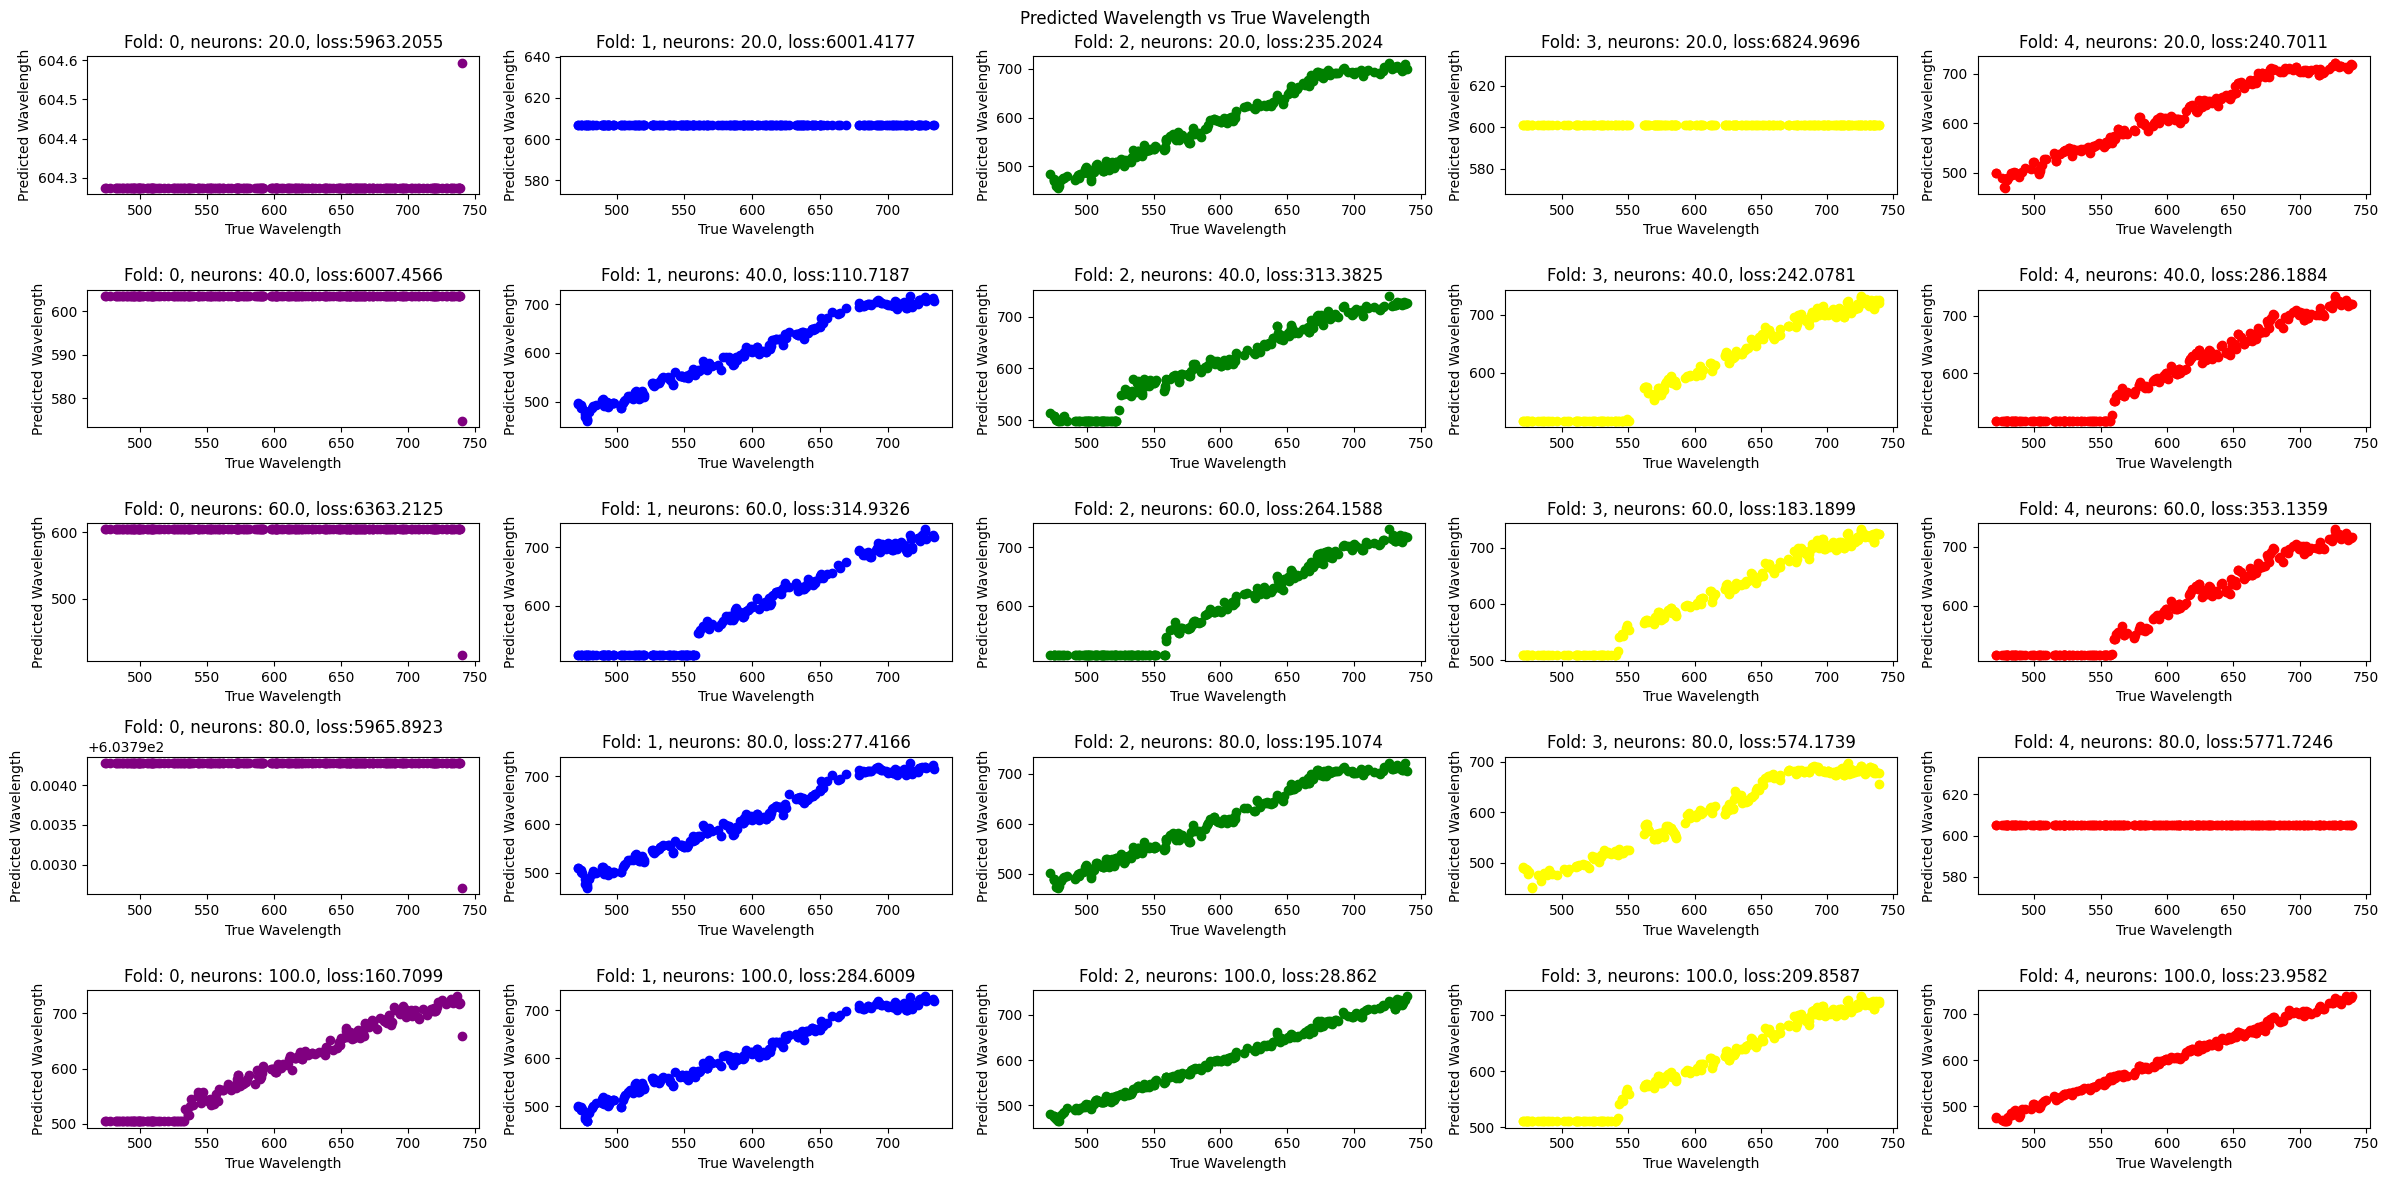

Mean MSE in training set: 1870.454115672679
Mean MSE in validation set: 1887.850186707077
MSE for test data: 22.806603779074738


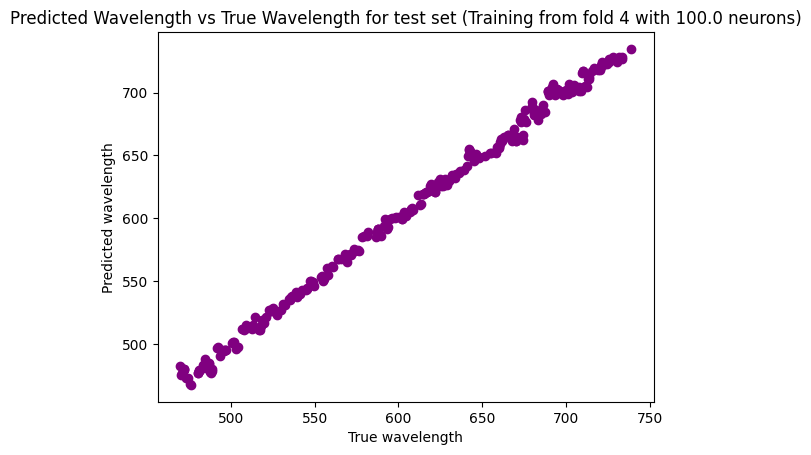

In [20]:
# Define network architecture
initial_neuron = 20
final_neuron = 100
num_steps = 5
num_neurons = np.linspace(initial_neuron, final_neuron, num_steps)

# for storing the errors corresponding to each neuron number
mlp_val_errors = []
mlp_train_errors = []

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_steps, ncols=Num_Folds, figsize=(24, 12))

#KFold
for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train, y_val = y_trainNVal[train_index], y_trainNVal[val_index]

    # MLP
    for i, neuron_count in enumerate(num_neurons):
        # compute the size of the hidden layer
        hidden_layer_sizes = int(neuron_count)
    
        # create MLP Regressor model
        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd', max_iter=2500, random_state=seed)
    
        # fit the model on trainig data
        model.fit(X_train, y_train)
    
        # make predictions on the training data
        y_train_pred = model.predict(X_train)
    
        # make predictions on the validation data
        y_val_pred = model.predict(X_val)
    
        # calculate MSE for this fold and this number of neurons on the train and validation data and append it to the val_errors and train_errors
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_val = mean_squared_error(y_val, y_val_pred)
        mlp_train_errors.append(mse_train)
        mlp_val_errors.append(mse_val)

    
        # if this has the min error, calculate for test set
        if mse_val == min(mlp_val_errors):
            best_fold = fold_num
            best_neurons = neuron_count
            y_test_pred = model.predict(X_test_scaled)
            
        # Add the figure to the plot
        axs[i, fold_num].scatter(y_val, y_val_pred, color=colours[fold_num])
        axs[i, fold_num].set_xlabel('True Wavelength')
        axs[i, fold_num].set_ylabel('Predicted Wavelength')
        axs[i, fold_num].set_title(f'Fold: {fold_num}, neurons: {neuron_count}, loss:{round(mse_val, 4)}')
            
plt.suptitle('Predicted Wavelength vs True Wavelength')
plt.tight_layout()
plt.show()
        
# compute MSE for the training, validation and test sets
mean_mse_train = np.mean(mlp_train_errors)
mean_mse_val = np.mean(mlp_val_errors)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Mean MSE in training set:', mean_mse_train)
print('Mean MSE in validation set:', mean_mse_val)
print('MSE for test data:', test_mse)

plt.scatter(y_test, y_test_pred, color='purple')
plt.xlabel('True wavelength')
plt.ylabel('Predicted wavelength')
plt.title(f'Predicted Wavelength vs True Wavelength for test set (Training from fold {fold_num} with {best_neurons} neurons)')
plt.show()